fine-tuning a pretrained object detection model

following tutorial: [fine-tuning pre-triained models](https://docs.pytorch.org/tutorials/intermediate/torchvision_tutorial.html)

In [1]:
import load_statues
import load_pytorch_models
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

#add 1 to number of classes to preserve class 0, but constraints of the pretrained model
num_classes_custom = len(load_statues.class_mapping)  + 1 #9
print(f'num_classes_custom={num_classes_custom}')

num_classes_custom=10


In [2]:
model = load_pytorch_models.get_faster_rcnn(num_classes_custom)

in_features=1024


In [3]:
#model2 = load_pytorch_models.get_faster_rcnn_with_masks(num_classes_custom)

In [4]:
#putting these in bin... change as needed
module_dir = os.path.join(os.getcwd(), '..', 'bin')
sys.path.append(module_dir)
if not os.path.exists(os.path.join(module_dir, "utils.py")):
    !curl -L "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py" -o ../bin/engine.py
    !curl -L "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py" -o ../bin/utils.py
    !curl -L "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py" -o ../bin/coco_utils.py
    !curl -L "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py" -o ../bin/coco_eval.py
    !curl -L "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py" -o ../bin/transforms.py

import utils

category_index, dataset, dataset_test = load_statues.load_gbman_3(\
    load_pytorch_models.get_transform(train=True))
#category_index, dataset, dataset_test = load_statues.load_statues(\
#    load_pytorch_models.get_transform(train=True))

print(f'load data')
data_loader = torch.utils.data.DataLoader(dataset,\
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn)

if False:
    print(f'check inputs accepted by model')
    _images, _targets = next(iter(data_loader))
    _images = list(image for image in _images)
    _targets = [{k: v for k, v in t.items()} for t in _targets]
    output = model(_images, _targets)  # Returns losses and detections
    print(output)

data_loader_test = torch.utils.data.DataLoader(dataset_test,\
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn)

from engine import train_one_epoch, evaluate

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

load data


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

run pre-trained model on test data
labels[(0, 0)]=['1: 0.630', '1: 0.117', '1: 0.113', '1: 0.102', '1: 0.099', '1: 0.083', '1: 0.081', '1: 0.076', '1: 0.076', '1: 0.076', '1: 0.072', '1: 0.056', '1: 0.055', '1: 0.054', '1: 0.053', '1: 0.051']


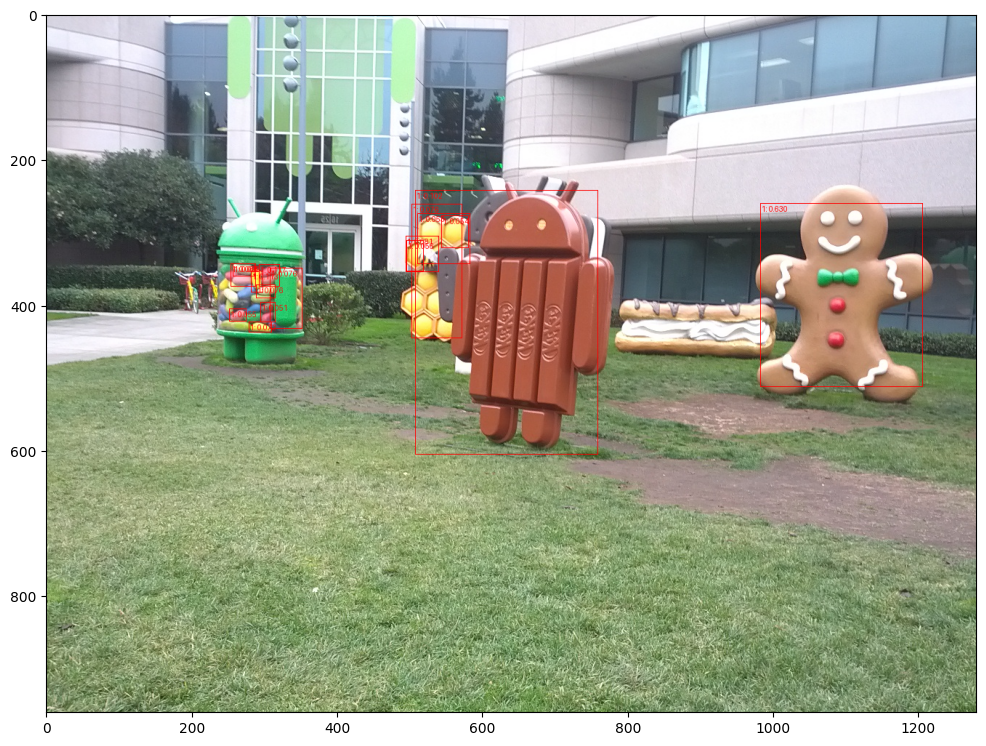

labels[(1, 0)]=['1: 0.178', '1: 0.138', '1: 0.102', '1: 0.098', '1: 0.096', '1: 0.064', '1: 0.055', '1: 0.052']


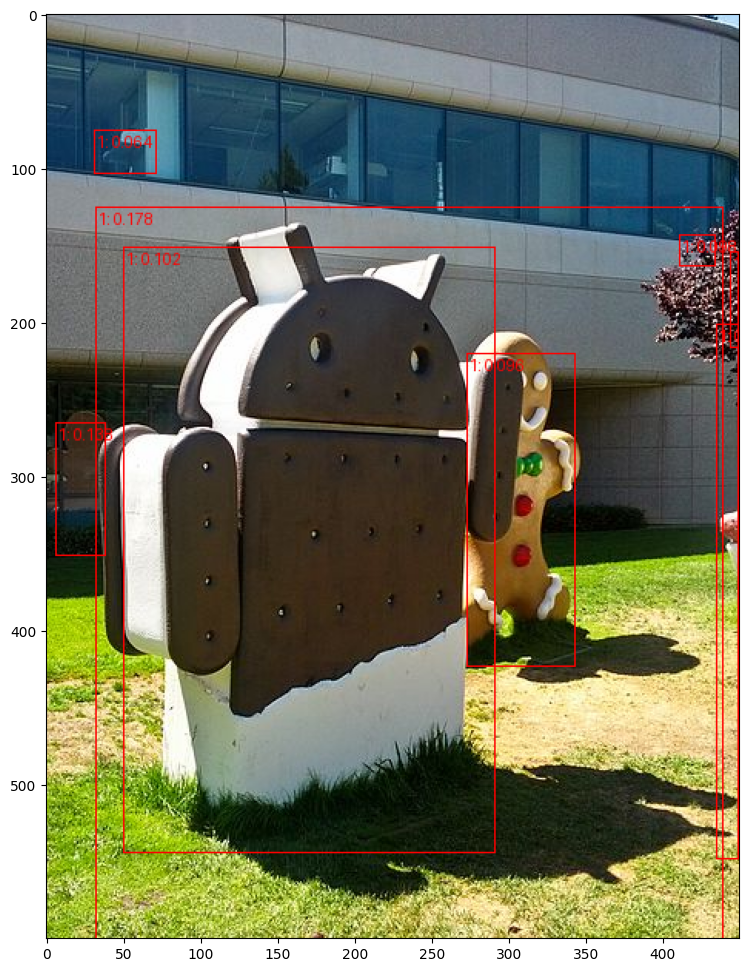

begin fine-tuning
Epoch: 0, Loss: 0.1485755741596222
Epoch: 0, Loss: 0.10217621177434921
Epoch: 0, Loss: 0.07980617135763168
Epoch: 1, Loss: 0.10471760481595993
Epoch: 1, Loss: 0.09418453276157379
Epoch: 1, Loss: 0.07876455038785934
Epoch: 2, Loss: 0.13721971213817596
Epoch: 2, Loss: 0.07822670042514801
Epoch: 2, Loss: 0.09193333983421326
Epoch: 3, Loss: 0.0750751867890358
Epoch: 3, Loss: 0.057234395295381546
Epoch: 3, Loss: 0.05972674489021301
evalulate fine-tuned model on test data
['1: 0.919', '1: 0.086', '1: 0.069', '1: 0.064', '1: 0.058', '1: 0.052']


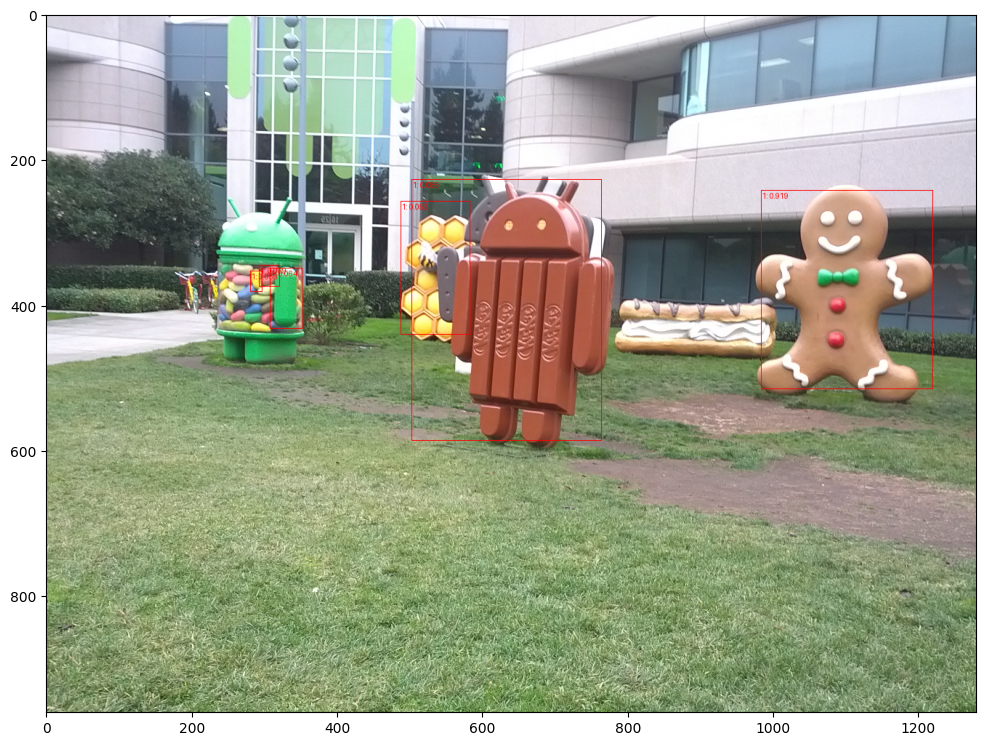

['1: 0.511', '1: 0.506', '1: 0.128', '1: 0.080', '1: 0.054', '1: 0.052']


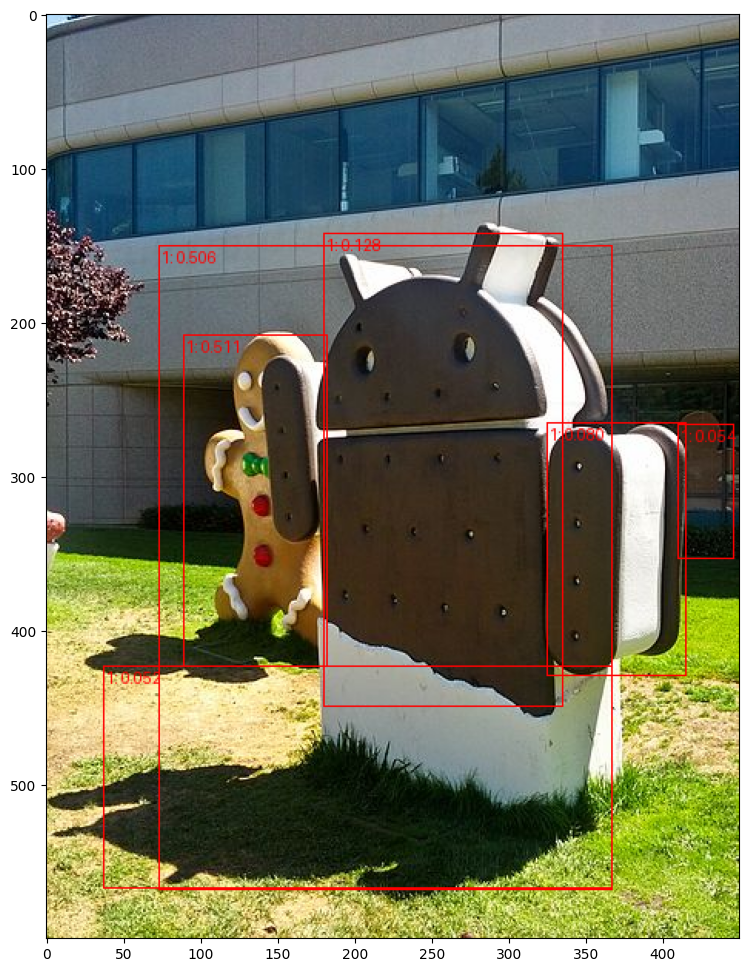

In [7]:
# check test results w/o training
%matplotlib inline
print('run pre-trained model on test data')
model.eval()
with torch.no_grad():
    j = 0
    for images, targets in data_loader_test:
        images = [img.to(device) for img in images]
        # targets = [{k: v.to(device) for k, v in t.items()} for t in targets] # If targets are dicts
        # Forward pass
        predictions = model(images)
        for i, img in enumerate(images):
            image = (255.0 * (img - img.min()) / (img.max() - img.min())).to(torch.uint8)
            image = image[:3, ...]
            pred_labels = [f"{label}: {score:.3f}" for label, score in zip(predictions[i]["labels"], predictions[i]["scores"])]
            pred_boxes = predictions[i]["boxes"].long()
            output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")
            plt.figure(figsize=(12, 12))
            plt.imshow(output_image.permute(1, 2, 0))
            print(f'labels[{j, i}]={pred_labels}')
            plt.show()
        j+=1
print('begin fine-tuning')

learning_rate = 0.001
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=learning_rate)

epochs = 4

model.train()
for epoch in range(epochs):
    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        # Zero the gradients
        optimizer.zero_grad()

        # Backward pass
        losses.backward()

        # Update model parameters
        optimizer.step()

        # Print or log training progress
        print(f"Epoch: {epoch}, Loss: {losses.item()}")

'''
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)
num_epochs = 2
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)
print('done training')
'''

print('evalulate fine-tuned model on test data')

model.eval()
with torch.no_grad():
    for images, targets in data_loader_test:
        images = [img.to(device) for img in images]
        # targets = [{k: v.to(device) for k, v in t.items()} for t in targets] # If targets are dicts
        # Forward pass
        predictions = model(images)
        for i,img in enumerate(images):
            image = (255.0 * (img - img.min()) / (img.max() - img.min())).to(torch.uint8)
            image = image[:3, ...]
            pred_labels = [f"{label}: {score:.3f}" for label, score in zip(predictions[i]["labels"], predictions[i]["scores"])]
            pred_boxes = predictions[i]["boxes"].long()
            output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")
            plt.figure(figsize=(12, 12))
            plt.imshow(output_image.permute(1, 2, 0))
            print(pred_labels)
            plt.show()
            